# 弾道計算を最適化問題に落とし込んで解いてみるお試しプロジェクト

- 目的
    - モデル化とパラメータ最適化でどんな問題でも解くことができることを実証する
- 目標
    - 弾道計算で、弾丸の初速度と発射角度をパラメータとして、標的に命中させるための最適解を求める
- 手段
    - 弾道計算を最初はシンプルな問題から始めてだんだん要素を追加して難易度を上げることで解析的には解けない問題でも最適化問題に落とし込んで解けることを示す
    - 最適化には確率的な要素も含めたいのでmcmcを使う


# 発射機側のプラントモデルを作成
- 単純な運動方程式モデルで実装
- 時間シミュレーションを漸化式に基づいて実行する

In [11]:
# ボールを投げたときの初速度と角度をパラメータとして、ボールの軌道計算を関数の形に書き直したコード

# 必要なモジュールをインポート
import math
import matplotlib.pyplot as plt

In [12]:
# ボールの軌道計算をする関数を定義
def ball_trajectory(v0, theta, g, dt):
    # 角度をラジアンに変換
    theta = math.radians(theta)

    # 水平方向と垂直方向の初速度を計算
    vx = v0 * math.cos(theta) # 水平方向の初速度 (m/s)
    vy = v0 * math.sin(theta) # 垂直方向の初速度 (m/s)

    # 初期位置と時間を設定
    x = 0 # 初期位置 (m)
    y = 0 # 初期位置 (m)
    t = 0 # 初期時間 (s)

    # 位置と時間のリストを作成
    x_list = [x] # 水平方向の位置のリスト (m)
    y_list = [y] # 垂直方向の位置のリスト (m)
    t_list = [t] # 時間のリスト (s)

    # ボールが地面に着くまで繰り返す
    while y >= 0:
        # 次の位置と時間を計算
        x = x + vx * dt # 次の水平方向の位置 (m)
        y = y + vy * dt - 0.5 * g * dt**2 # 次の垂直方向の位置 (m)
        t = t + dt # 次の時間 (s)

        # 次の垂直方向の速度を計算
        vy = vy - g * dt # 次の垂直方向の速度 (m/s)

        # 位置と時間のリストに追加
        x_list.append(x) # 水平方向の位置のリストに追加 (m)
        y_list.append(y) # 垂直方向の位置のリストに追加 (m)
        t_list.append(t) # 時間のリストに追加 (s)

    # 位置と時間のリストを返す
    return x_list, y_list, t_list


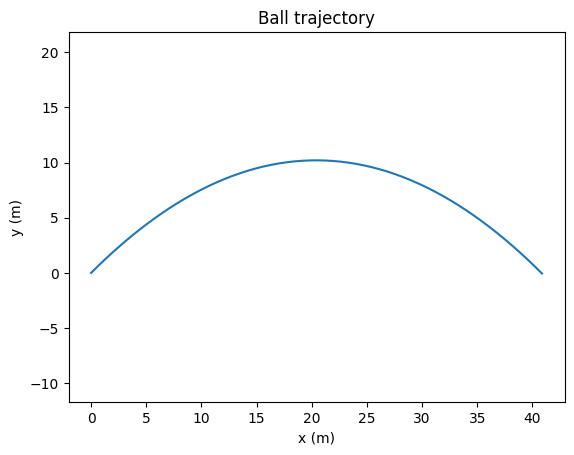

In [13]:
# パラメータの設定
v0 = 20 # 初速度 (m/s)
theta = 45 # 投げる角度 (度)
g = 9.8 # 重力加速度 (m/s^2)
dt = 0.01 # 時間間隔 (s)

# ボールの軌道計算をする関数を呼び出す
x_list, y_list, t_list = ball_trajectory(v0, theta, g, dt)

# ボールの軌道をプロット
plt.plot(x_list, y_list) # ボールの軌道をプロット
plt.xlabel("x (m)") # x軸のラベル
plt.ylabel("y (m)") # y軸のラベル
plt.title("Ball trajectory") # タイトル
plt.axis('equal') # 縦横比を等しくする
plt.show() # グラフを表示
